# Cluster-based permutation test

The cluster-based permutation test is a non-parametric test to reveal if two conditions are significantly different. I know that this test can be a bit difficult to wrap your head around. Here are some additional resources that I found helpful:

- [Intro to cluster permutation statistics](https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/)
- [How not to interpret the results](https://www.fieldtriptoolbox.org/faq/how_not_to_interpret_results_from_a_cluster-based_permutation_test/)
- [MNE-tutorial](https://mne.tools/stable/auto_tutorials/stats-sensor-space/75_cluster_ftest_spatiotemporal.html#sphx-glr-auto-tutorials-stats-sensor-space-75-cluster-ftest-spatiotemporal-py)
- [Fieldtrip tutorial (includes a video)]([https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_timelock/](https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_timelock/))
- [The original paper introducing the test](https://pubmed.ncbi.nlm.nih.gov/17517438/)

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_ipynb_kernel.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

## Introduction to the cluster-based permutation test


Shoutout to Mina for the following steps to perform the cluster-based permutation test:
1. Set threshold for t-values (contrast) for clustering
2. Compare conditions: get t-values for the contrast (for the difference in the two conditions) for each time-stamp
3. Form cluster out of t-values for the contrast (two conditions) that go beyond the threshold. Sum the t-values of that particular cluster together with all the neighbouring channels (to get the space dimension). Do this for all the data
4. Take the highest t-value sum among all the clusters you identify. Save this number.
5. PERMUTATION: Shuffle the two conditions i.e., making an empirical null distribution
7. Repeat step 2-4 for the new distribution (data that was shuffled) - recommended to repeat this step 10,000). Save the highest t-value sums of the clusters for each run (i.e., you will end up with 10,000 highest t-value sums)
8. Make a distribution of the 10,000 highest t-value sums 
9. If initial highest t-value value (*from step 4*) is outside the distribution (larger or smaller) then you say that you have a significant difference between the two conditions

Luckily, we don't have to do this by hand and we can use one of the `mne-python` functions to do this. However, it is important to understand the steps above to understand the output of the function. 

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

## Load the data
First, we load in the data from the three participants and save them in a variable called `all_epochs`, which is a list of `mne.Epochs` objects.

In [2]:
# load in the data
all_epochs = []

data_path = Path("/work/EEG_lab/example_data")

for participant in ["Group1", "Group5", "Group6"]:
    epochs = mne.read_epochs(data_path / f"{participant}-epo.fif", verbose=False, preload=True)

    # only keep eeg channels
    epochs.pick(["eeg"])

    all_epochs.append(epochs)


print(type(all_epochs)) # we have now created a list of epochs objects
print(len(all_epochs)) # we have 3 epochs objects in the list
print(type(all_epochs[0])) # we can access the first epochs object in the list which is a Epochs object

<class 'list'>
3
<class 'mne.epochs.EpochsFIF'>


## Extract the data
For the purpose of this example we will be checking if there is a difference between images and words.

In [3]:
epochs_image = [epochs["Image"] for epochs in all_epochs] # we can use a list comprehension to extract the incorrect trials for each participant
epochs_word = [epochs["Word"] for epochs in all_epochs] # we can use a list comprehension to extract the correct trials for each participant

# obtain the data as a 3D matrix and transpose it such that
# the dimensions are as expected for the cluster permutation test:
# n_epochs × n_times × n_channels
data_incorrect = [np.transpose(epochs.get_data(copy = True), (0, 2, 1)) for epochs in epochs_image]
data_correct = [np.transpose(epochs.get_data(copy = True), (0, 2, 1)) for epochs in epochs_word]

print(data_correct[1].shape) # we can see that the dimensions are now as expected
print(data_incorrect[1].shape) # we can see that the dimensions are now as expected

(57, 175, 28)
(57, 175, 28)


## Concatenate data from participants
We will concatenate the data from the three participants into one numpy array as a preparation for the cluster-based permutation test.


In [4]:
X_incorrect = np.concatenate(data_incorrect, axis=0) # concatenate the data for all participants
X_correct = np.concatenate(data_correct, axis=0) # concatenate the data for all participants

## Get adjecency matrix
We need to define the adjacency matrix to be able to cluster the data. This is a matrix that defines which channels are neighbours.

In [5]:
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, ch_type="eeg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28


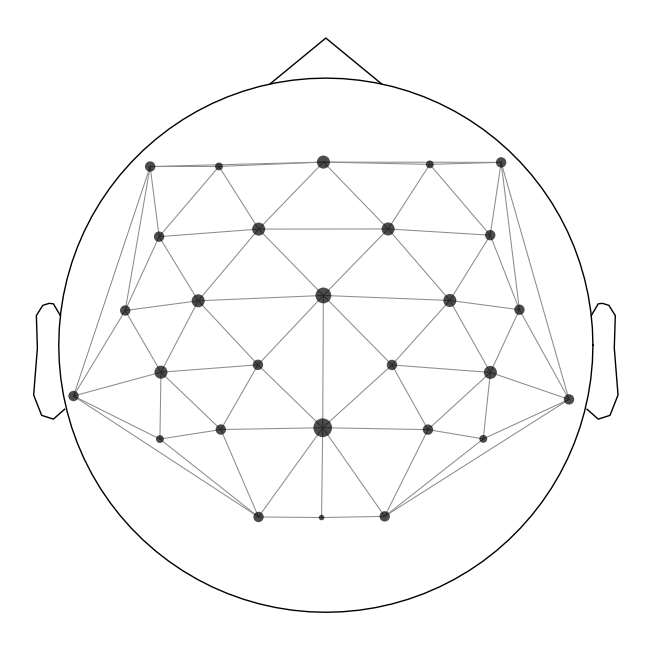

In [6]:
# plot the adjacency
mne.viz.plot_ch_adjacency(epochs.info, adjacency, ch_names);

In [7]:
# set family-wise p-value
p_accept = 0.1

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(
    [X_correct, X_incorrect], 
    n_permutations=1000, 
    tail=0,
    n_jobs=-1, 
    adjacency=adjacency, 
    seed=4)

# selecting clusters with significant p-values
F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 3.869036
stat_fun(H1): min=0.000000 max=39.919953
Running initial clustering …
Found 21 clusters


/tmp/ipykernel_6528/4172100370.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

## Plot the clusters

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


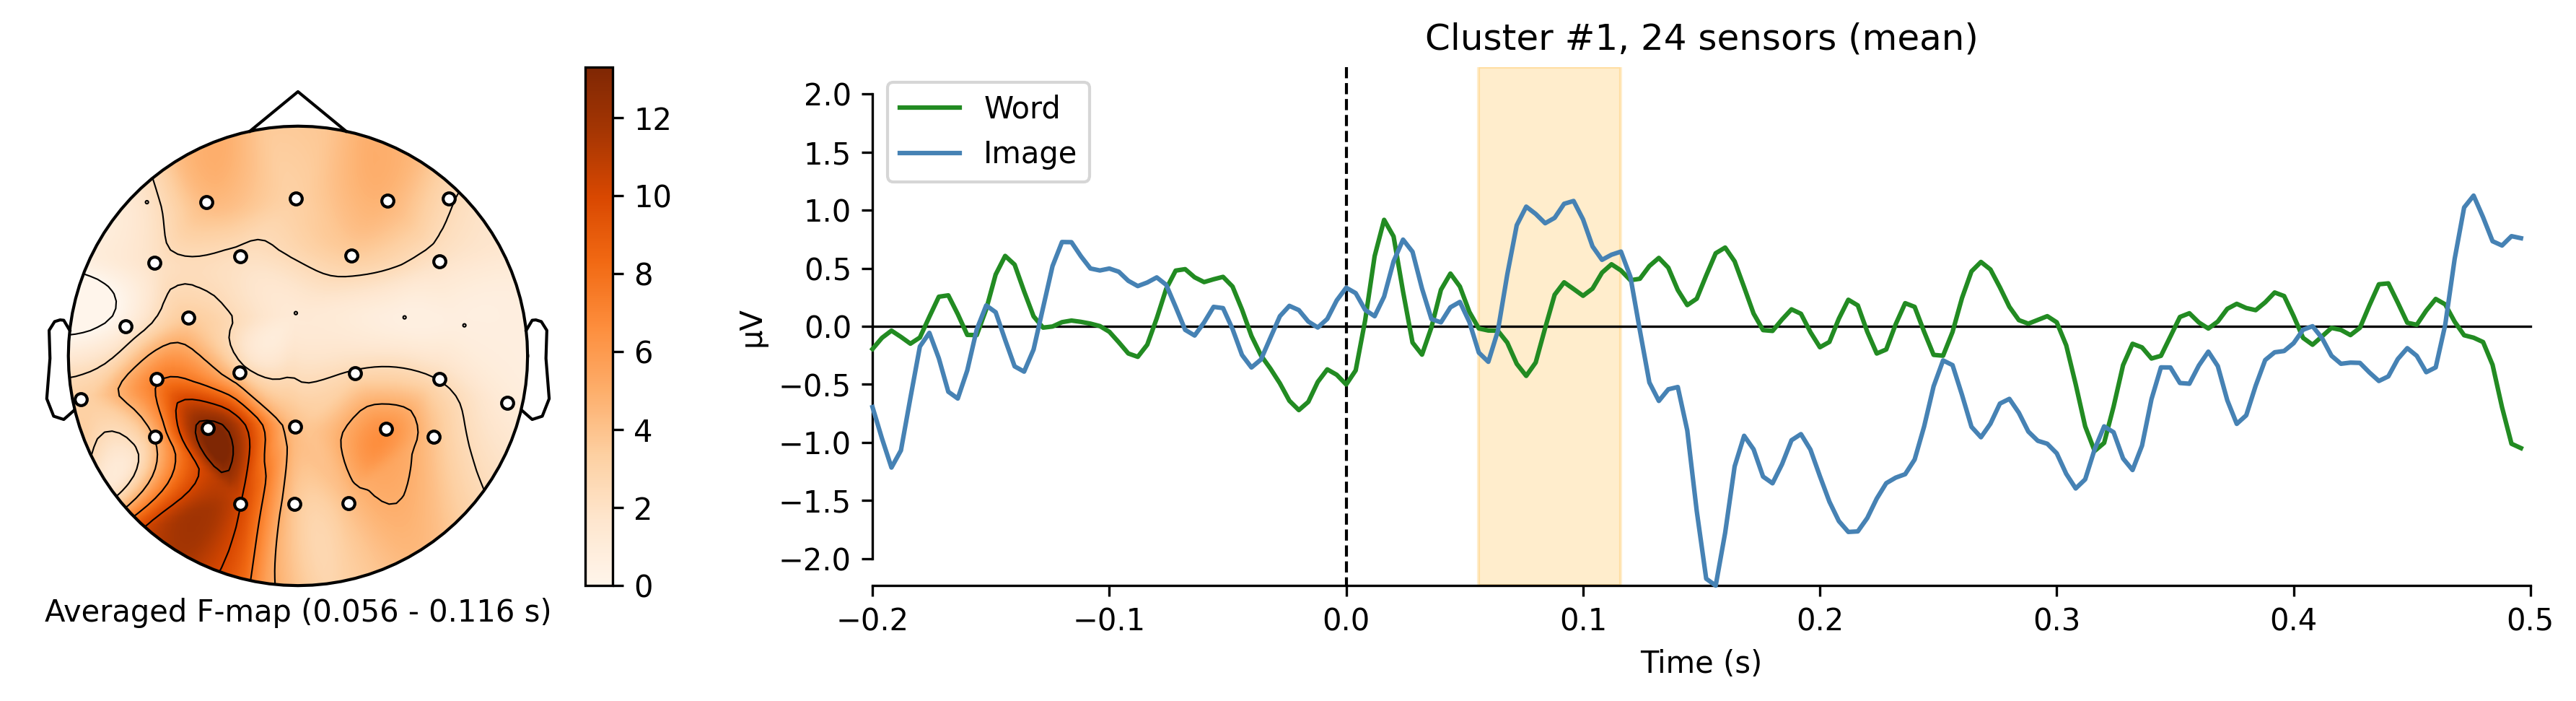

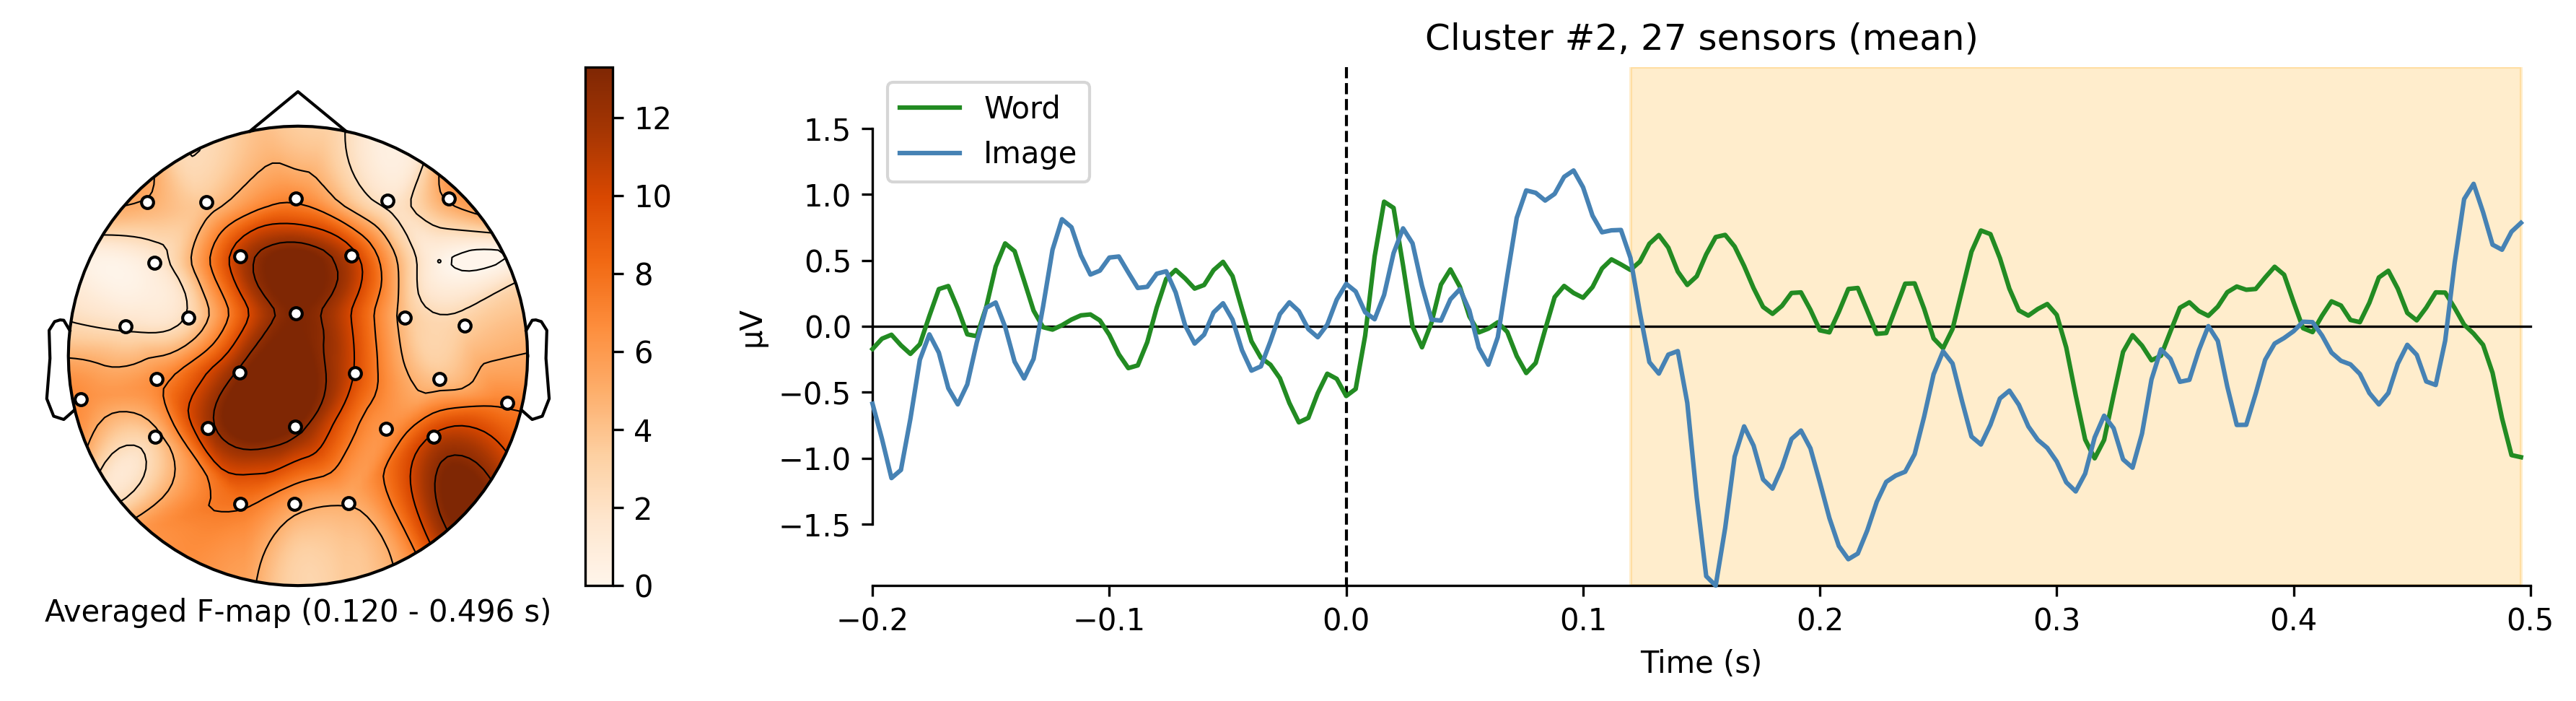

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
colors = {"Word": "forestgreen", "Image": 'steelblue'}

# organising data for plotting
evokeds = {cond: epochs[cond].average() for cond in ['Word', 'Image']} 

if len(good_cluster_inds) == 0:
    print('No significant clusters found')

else:
    # looping over clusters
    for i_clu, clu_idx in enumerate(good_cluster_inds):
        # unpacking cluster information
        time_inds, space_inds = np.squeeze(clusters[clu_idx])
        ch_inds = np.unique(space_inds)
        time_inds = np.unique(time_inds)

        # topography for stats
        f_map = F_obs[time_inds, ...].mean(axis=0)

        # getting signals at the sensors contributing to the cluster
        sig_times = epochs.times[time_inds]

        # creating spatial mask
        mask = np.zeros((f_map.shape[0], 1), dtype=bool)
        mask[ch_inds, :] = True

        # initialising the figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

        # plotting average test statistic and mark significant sensors
        image = mne.viz.plot_topomap(
            f_map, 
            evokeds["Image"].info, 
            axes=ax_topo, 
            cmap="Oranges", 
            show=False, 
            mask=mask
            )

        # creating additional axes (for ERP and colorbar)
        divider = make_axes_locatable(ax_topo)

        # adding axes for colourbar
        ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(image[0], cax=ax_colorbar)
        ax_topo.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

        # adding new axis for time courses and plot time courses
        ax_signals = divider.append_axes('right', size='300%', pad=1.2)
        title = f'Cluster #{i_clu + 1}, { len(ch_inds)} sensors'
        
        mne.viz.plot_compare_evokeds(
            evokeds, 
            title=title, 
            picks=ch_inds, 
            axes=ax_signals,
            colors=colors, 
            show=False,
            combine = "mean" # you can also plot GFP if you prefer 
            )

        # plotting temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()

        # fill between ymin and ymax for all clusters 
        ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                                color='orange', alpha=0.2)

        plt.tight_layout()